In [100]:
from sklearn import preprocessing
import PIL.Image as pilimg
import matplotlib.pyplot as plt
import csv
import numpy as np
from numpy import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from models.densenet import densenet121
from models.vgg import VGGNet

%matplotlib inline 

# Data Preprocessing

In [2]:
class C100Dataset:
    """
    X is a feature vector
    Y is the predictor variable
    """

    def __init__(self, filename):
        ## read the csv for dataset (cifar100.csv, cifar100_lt.csv or cifar100_nl.csv), 
        # 
        # Format:
        #   image file path,classname
        
        ### TODO: Read the csv file and make the training and testing set
        ## YOUR CODE HERE
        self.filename=filename
        f=open(filename)
        rdr=csv.reader(f)
        path=[]
        label=[]
        
        for line in rdr:
            rpath=line[0].replace('cifar100','../dataset')
            path.append(rpath)
            label.append(line[1])
        f.close()

        self.tr_x = []
        self.tr_y = []
        self.ts_x = []
        self.ts_y = []


        for i in range(len(label)):
            img = pilimg.open(path[i])#path 읽어와서 이미지 열기
            pixel = np.array(img)
            pixel = np.transpose(pixel, (2, 1, 0))
            cat=path[i].split('/')
            if cat[3]=='train':
                self.tr_x.append(pixel)
                self.tr_y.append(label[i])
            else:
                self.ts_x.append(pixel)
                self.ts_y.append(label[i])
                
    def getDataset(self):
        self.tr_x = np.array(self.tr_x)
        self.ts_x = np.array(self.ts_x)
        
        le = preprocessing.LabelEncoder()
        le.fit(self.tr_y)
        self.tr_y = le.transform(self.tr_y)
        
        le.fit(self.ts_y)
        self.ts_y = le.transform(self.ts_y)
        
        return [self.tr_x, self.tr_y, self.ts_x, self.ts_y]

In [91]:
dataset_odn = C100Dataset('../dataset/data/cifar100.csv')
[data_odn_tr_x, data_odn_tr_y, data_odn_ts_x, data_odn_ts_y] = dataset_odn.getDataset()

In [92]:
data_odn_tr_x = torch.Tensor(data_odn_tr_x)
data_odn_ts_x = torch.Tensor(data_odn_ts_x)

In [93]:
type(data_odn_tr_y)

numpy.ndarray

In [94]:
train_dataset = []
for i, (tr_y) in enumerate(data_odn_tr_y):
    train_dataset.append((data_odn_tr_x[i],int(tr_y)))
    
test_dataset = []
for i, (ts_y) in enumerate(data_odn_ts_y):
    test_dataset.append((data_odn_ts_x[i],int(ts_y)))

In [95]:
len(train_dataset)

50000

In [96]:
len(test_dataset)

10000

In [109]:
# device setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 30 # number of epochs for train
batch_size = 32 # do not change this value 128
learning_rate = 0.0001 # do not change this value
num_classes = 100

cuda:0


In [110]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Training

In [111]:
# train and test
# model = VGGNet(num_classes=num_classes).to(device)
model = densenet121().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottle_neck_layer_0): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottle_neck_layer_1): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(12

In [112]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [113]:
train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    model.train()

    losses = AverageMeter()
    acces = AverageMeter()
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        
        losses.update(loss.item(), labels.size(0))
        acces.update(100 * correct / batch_size, labels.size(0))

        if (i + 1) % 100 == 0:
            print('Epoch: {}/{}, Batch Step: {}/{}, Loss: {:.4f}, Training Accuracy of the Current Batch: {}%'.
                  format(epoch + 1, num_epochs, i + 1, train_loader.__len__(), loss.item(), 100 * correct / batch_size))
            
    train_loss_arr.append(losses.avg)
    train_acc_arr.append(acces.avg)

    model.eval()

    with torch.no_grad():
        total, correct  = 0, 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            losses.update(loss.item(), labels.size(0))

        val_loss_arr.append(losses.avg)
        val_acc_arr.append(100 * correct / total)

        print('Test Accuracy of the 10,000 Test Images: {}%\n'.format(100 * correct / total))
    
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("number of parameters:", pytorch_total_params)

Epoch: 1/100, Batch Step: 100/1563, Loss: 4.1868, Training Accuracy of the Current Batch: 9.375%
Epoch: 1/100, Batch Step: 200/1563, Loss: 4.1840, Training Accuracy of the Current Batch: 9.375%
Epoch: 1/100, Batch Step: 300/1563, Loss: 3.5825, Training Accuracy of the Current Batch: 12.5%
Epoch: 1/100, Batch Step: 400/1563, Loss: 3.9900, Training Accuracy of the Current Batch: 3.125%
Epoch: 1/100, Batch Step: 500/1563, Loss: 3.7828, Training Accuracy of the Current Batch: 25.0%
Epoch: 1/100, Batch Step: 600/1563, Loss: 3.7700, Training Accuracy of the Current Batch: 9.375%
Epoch: 1/100, Batch Step: 700/1563, Loss: 3.1395, Training Accuracy of the Current Batch: 28.125%
Epoch: 1/100, Batch Step: 800/1563, Loss: 3.2438, Training Accuracy of the Current Batch: 21.875%
Epoch: 1/100, Batch Step: 900/1563, Loss: 3.1618, Training Accuracy of the Current Batch: 21.875%
Epoch: 1/100, Batch Step: 1000/1563, Loss: 3.1102, Training Accuracy of the Current Batch: 18.75%
Epoch: 1/100, Batch Step: 11

Epoch: 6/100, Batch Step: 800/1563, Loss: 1.1144, Training Accuracy of the Current Batch: 65.625%
Epoch: 6/100, Batch Step: 900/1563, Loss: 1.1449, Training Accuracy of the Current Batch: 59.375%
Epoch: 6/100, Batch Step: 1000/1563, Loss: 1.0940, Training Accuracy of the Current Batch: 56.25%
Epoch: 6/100, Batch Step: 1100/1563, Loss: 0.9245, Training Accuracy of the Current Batch: 62.5%
Epoch: 6/100, Batch Step: 1200/1563, Loss: 1.3170, Training Accuracy of the Current Batch: 68.75%
Epoch: 6/100, Batch Step: 1300/1563, Loss: 1.2541, Training Accuracy of the Current Batch: 56.25%
Epoch: 6/100, Batch Step: 1400/1563, Loss: 0.9682, Training Accuracy of the Current Batch: 65.625%
Epoch: 6/100, Batch Step: 1500/1563, Loss: 1.4599, Training Accuracy of the Current Batch: 59.375%
Test Accuracy of the 10,000 Test Images: 57.57%

Epoch: 7/100, Batch Step: 100/1563, Loss: 1.0495, Training Accuracy of the Current Batch: 65.625%
Epoch: 7/100, Batch Step: 200/1563, Loss: 0.5841, Training Accuracy 

Epoch: 11/100, Batch Step: 1500/1563, Loss: 0.4535, Training Accuracy of the Current Batch: 84.375%
Test Accuracy of the 10,000 Test Images: 62.38%

Epoch: 12/100, Batch Step: 100/1563, Loss: 0.3444, Training Accuracy of the Current Batch: 87.5%
Epoch: 12/100, Batch Step: 200/1563, Loss: 0.2057, Training Accuracy of the Current Batch: 96.875%
Epoch: 12/100, Batch Step: 300/1563, Loss: 0.4687, Training Accuracy of the Current Batch: 84.375%
Epoch: 12/100, Batch Step: 400/1563, Loss: 0.3380, Training Accuracy of the Current Batch: 84.375%
Epoch: 12/100, Batch Step: 500/1563, Loss: 0.6165, Training Accuracy of the Current Batch: 78.125%
Epoch: 12/100, Batch Step: 600/1563, Loss: 0.4621, Training Accuracy of the Current Batch: 84.375%
Epoch: 12/100, Batch Step: 700/1563, Loss: 0.5611, Training Accuracy of the Current Batch: 81.25%
Epoch: 12/100, Batch Step: 800/1563, Loss: 0.7257, Training Accuracy of the Current Batch: 75.0%
Epoch: 12/100, Batch Step: 900/1563, Loss: 0.4582, Training Accu

Epoch: 17/100, Batch Step: 600/1563, Loss: 0.2100, Training Accuracy of the Current Batch: 90.625%
Epoch: 17/100, Batch Step: 700/1563, Loss: 0.3748, Training Accuracy of the Current Batch: 87.5%
Epoch: 17/100, Batch Step: 800/1563, Loss: 0.1949, Training Accuracy of the Current Batch: 90.625%
Epoch: 17/100, Batch Step: 900/1563, Loss: 0.1879, Training Accuracy of the Current Batch: 96.875%
Epoch: 17/100, Batch Step: 1000/1563, Loss: 0.1996, Training Accuracy of the Current Batch: 87.5%
Epoch: 17/100, Batch Step: 1100/1563, Loss: 0.2489, Training Accuracy of the Current Batch: 87.5%
Epoch: 17/100, Batch Step: 1200/1563, Loss: 0.3853, Training Accuracy of the Current Batch: 96.875%
Epoch: 17/100, Batch Step: 1300/1563, Loss: 0.3987, Training Accuracy of the Current Batch: 84.375%
Epoch: 17/100, Batch Step: 1400/1563, Loss: 0.1623, Training Accuracy of the Current Batch: 96.875%
Epoch: 17/100, Batch Step: 1500/1563, Loss: 0.3181, Training Accuracy of the Current Batch: 87.5%
Test Accurac

Epoch: 22/100, Batch Step: 1200/1563, Loss: 0.0767, Training Accuracy of the Current Batch: 96.875%
Epoch: 22/100, Batch Step: 1300/1563, Loss: 0.2930, Training Accuracy of the Current Batch: 93.75%
Epoch: 22/100, Batch Step: 1400/1563, Loss: 0.0716, Training Accuracy of the Current Batch: 96.875%
Epoch: 22/100, Batch Step: 1500/1563, Loss: 0.1465, Training Accuracy of the Current Batch: 96.875%
Test Accuracy of the 10,000 Test Images: 62.73%

Epoch: 23/100, Batch Step: 100/1563, Loss: 0.1368, Training Accuracy of the Current Batch: 93.75%
Epoch: 23/100, Batch Step: 200/1563, Loss: 0.1944, Training Accuracy of the Current Batch: 93.75%
Epoch: 23/100, Batch Step: 300/1563, Loss: 0.0367, Training Accuracy of the Current Batch: 100.0%
Epoch: 23/100, Batch Step: 400/1563, Loss: 0.0529, Training Accuracy of the Current Batch: 96.875%
Epoch: 23/100, Batch Step: 500/1563, Loss: 0.0324, Training Accuracy of the Current Batch: 100.0%
Epoch: 23/100, Batch Step: 600/1563, Loss: 0.1078, Training A

KeyboardInterrupt: 

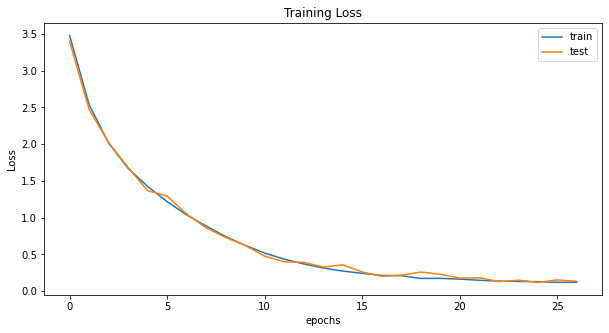

In [114]:
# draw the graph
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_loss_arr,label="train")
plt.plot(val_loss_arr,label="test")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

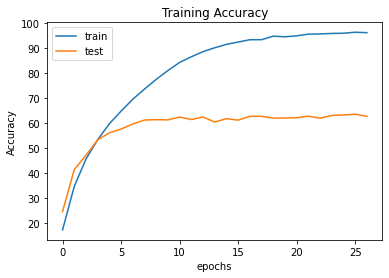

In [115]:
plt.title("Training Accuracy")
plt.plot(train_acc_arr,label="train")
plt.plot(val_acc_arr,label="test")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()